# P2 Unet Training and Validation Pipeline

Unet/Seg-former style model training and validation is included in this notebook.

The trained model will be used in ensemble which is implemented in Mask2Former+Unet.ipynb file.

In [1]:
''' 1. Module Import '''
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import random

!pip install segmentation-models-pytorch
!pip install rasterio
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR

import rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 122.5 MB/s eta 0:00:00


In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.8.0+cu126  Device: cuda


These r, g, b min/max values were calculated in Mask2Former.ipynb file.

In [ ]:
r_min = 1121.969
r_max = 4942.150
g_min = 1207.664
g_max = 4702.109
b_min = 1053.633
b_max = 4507.207

# r_min = 1045.748
# r_max = 6740.959
# g_min = 1102.797
# g_max = 6511.914
# b_min = 959.977
# b_max = 6216.434

In [ ]:
##label은 10/90으로 구성된다... 10이 검은색 /  90이 노란색

class SatelliteImageDataset(Dataset):
  def __init__(self,img_dir,label_dir,transform=None):
    self.img_dir=img_dir
    self.label_dir=label_dir
    self.transform=transform

    self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.tif')])
    self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.tif')])
    assert len(self.img_files) == len(self.label_files), "이미지와 레이블 수가 맞지 않습니다."

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_files[idx])
    label_path = os.path.join(self.label_dir, self.label_files[idx])

    with rasterio.open(img_path) as src:
      red   = src.read(1).astype(np.float32)
      green = src.read(2).astype(np.float32)
      blue  = src.read(3).astype(np.float32)

      red   = (red   - r_min) / (r_max - r_min)
      green = (green - g_min) / (g_max - g_min)
      blue  = (blue  - b_min) / (b_max - b_min)

      image = np.dstack((red, green, blue))
      image = image.clip(0, 1)

    with rasterio.open(label_path) as src:
      label=src.read(1)
      label=(label==10).astype(np.int64)  #label을 이진화

    if self.transform:
      image,label=self.transform(image,label)

    image=torch.from_numpy(image).float().permute(2,0,1)  #(H,W,C) => (C,H,W)
    label=torch.from_numpy(label).long()
    return image,label

In [ ]:
import cv2
import albumentations as A

def to_float32(img, **kwargs):
    return img.astype(np.float32, copy=False)

def keep_mask_int(msk, **kwargs):
    if msk.dtype != np.int64:
        msk = msk.astype(np.int64, copy=False)
    return msk

def clip01(img, **kwargs):
    return np.clip(img, 0.0, 1.0)

H, W = 512, 512

transform = A.Compose([
    A.Lambda(image=to_float32, mask=keep_mask_int),


    # A.OneOf([
    #     A.RandomResizedCrop(size=(H, W), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    #     A.Resize(H, W)
    # ], p=1.0),

    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=1.0),

    A.OneOf([
        A.GaussNoise(std_range=(0.0, 0.005), mean=0.0, p=1.0),
        A.MultiplicativeNoise(multiplier=(0.95, 1.05), per_channel=True, p=1.0),
    ], p=0.3),
    A.OneOf([
        A.GaussianBlur(blur_limit=(2, 3), p=1.0),
        A.MotionBlur(blur_limit=3, p=1.0),
    ], p=0.3),

    # A.OneOf([
    #     A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
    #     A.RandomGamma(gamma_limit=(80, 120), p=1.0),
    #     A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    # ], p=0.5),

    A.Lambda(image=clip01),
])


def augmentation(image, mask):
    # image: (H,W,3), float32, range (0,1)
    # mask : (H,W), int, 0/1
    out = transform(image=image, mask=mask)
    img_aug, msk_aug = out["image"], out["mask"]
    return img_aug, msk_aug

# transform = A.Compose(
#     [
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
#         A.RandomBrightnessContrast(
#             brightness_limit=0.2,
#             contrast_limit=0.0,
#             p=0.5
#         ),
#         A.GaussNoise(var_limit=(0.0, 0.0025), p=0.5),  # std≈0.05
#     ]
# )

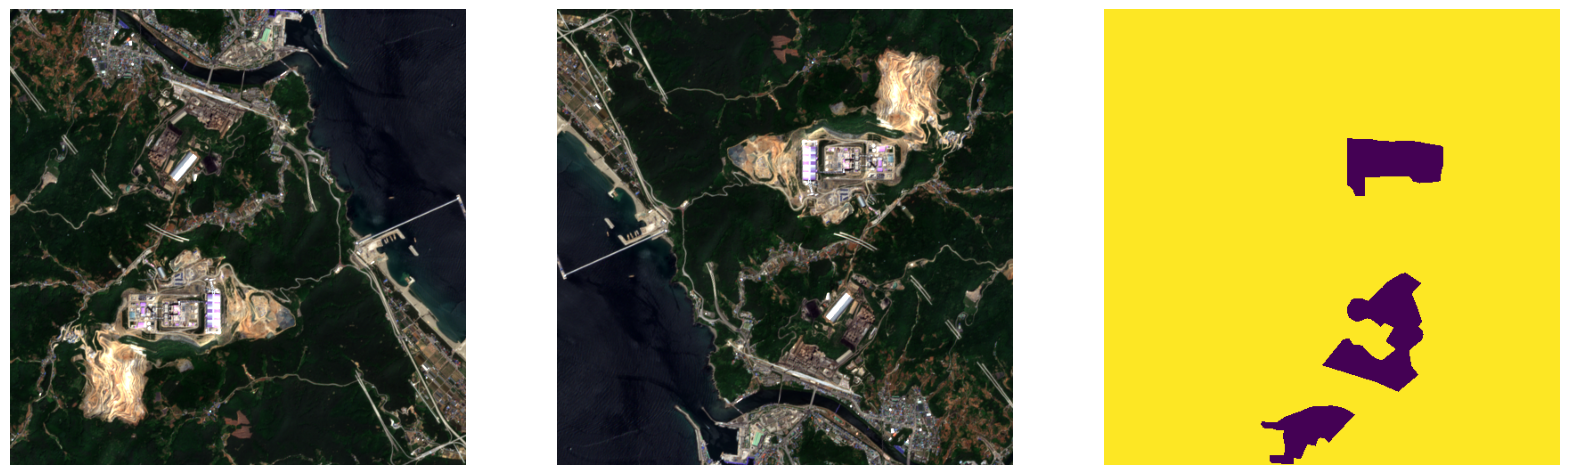

In [ ]:
file_name = '/root/workspace/train/TS_SN10_SN10/SN10_KOR_02030_240523.tif'
label_name = '/root/workspace/train/TL_SN10/SN10_KOR_02030_240523.tif'
with rasterio.open(file_name) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    red   = (red   - r_min)   / (r_max   - r_min)
    green = (green - g_min) / (g_max - g_min)
    blue  = (blue  - b_min)  / (b_max  - b_min)
    img = np.dstack((red, green, blue))
    img = img.clip(0, 1)

with rasterio.open(label_name) as src:
    label = src.read(1)
    label = (label==90).astype(np.int64)


fig, ax = plt.subplots(1, 3, figsize=(20,6))
ax[0].axis('off')
ax[0].imshow(img)
img, label = augmentation(img, label)
ax[1].axis('off')
ax[2].axis('off')
ax[1].imshow(img)
ax[2].imshow(label)

In [5]:
#hyperparameter set
batch_size = 8
lr = 0.0001
num_epochs = 31

In [ ]:
train_data = SatelliteImageDataset(img_dir='/root/workspace/train/TS_SN10_SN10',label_dir='/root/workspace/train/TL_SN10',transform=augmentation)
val_data = SatelliteImageDataset(img_dir='/root/workspace/valid/VS_SN10_SN10',label_dir='/root/workspace/valid/VL_SN10',transform=None)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
import segmentation_models_pytorch as smp
model=smp.Unet(
  encoder_name="mit_b5",
  encoder_weights="imagenet",
  in_channels=3,
  classes=2
).to(DEVICE)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

# Unet Training and Validation

Training logs are written in this cell output.

In [ ]:
# training and validation

model=smp.Unet(
  encoder_name="mit_b5",
  encoder_weights="imagenet",
  in_channels=3,
  classes=2
).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)
scheduler=CosineAnnealingLR(optimizer,T_max=15,eta_min=0.00001)

checkpoint_path = '/content/drive/MyDrive/300/mit_b5_model_noise.pth'

start_epoch = 0  # 기본 시작 epoch
if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, weights_only=False)
  model.load_state_dict(checkpoint['model'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  scheduler.load_state_dict(checkpoint['scheduler'])
  start_epoch = checkpoint['epoch'] + 1
  train_losses = checkpoint.get('train_losses', [])
  val_losses = checkpoint.get('val_losses', [])
  mious=checkpoint.get('mious',[])

else:
  train_losses = []
  val_losses = []
  mious=[]

for epoch in range(start_epoch):
  print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_losses[epoch]:.4f} | Val Loss: {val_losses[epoch]:.4f} | mIou: {mious[epoch]:.4f}")

for epoch in range(start_epoch,num_epochs):
    model.train()
    epoch_train_loss = []
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        output = model(imgs)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())

    avg_train_loss = np.array(epoch_train_loss).mean()
    train_losses.append(avg_train_loss)

    scheduler.step()

    model.eval()
    epoch_val_loss = []
    epoch_miou=[]
    intersection = torch.zeros(2, device=DEVICE)
    union = torch.zeros(2, device=DEVICE)
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(val_loader):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            output = model(imgs)
            loss = criterion(output, labels)
            epoch_val_loss.append(loss.item())
            # computing mIou
            preds = torch.argmax(output, dim=1)
            for c in range(2):
                pred_mask = (preds == c)
                true_mask = (labels == c)
                intersection[c] += (pred_mask & true_mask).sum()
                union[c] += (pred_mask | true_mask).sum()
        iou = intersection / (union + 1e-6)
        miou = iou.mean().item()
        epoch_miou.append(miou)
        avg_val_loss=np.array(epoch_val_loss).mean()
        avg_miou=np.array(epoch_miou).mean()
        val_losses.append(avg_val_loss)
        mious.append(avg_miou)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | mIou: {avg_miou:.4f}")
    torch.save({'model':model.state_dict(),'optimizer':optimizer.state_dict(),'scheduler':scheduler.state_dict(),'epoch':epoch,'train_losses': train_losses,'val_losses': val_losses,'mious':mious}, checkpoint_path)

Epoch [1/31] | Train Loss: 0.1439 | Val Loss: 0.0806 | mIou: 0.8975
Epoch [2/31] | Train Loss: 0.0665 | Val Loss: 0.0572 | mIou: 0.9247
Epoch [3/31] | Train Loss: 0.0461 | Val Loss: 0.0447 | mIou: 0.9411
Epoch [4/31] | Train Loss: 0.0350 | Val Loss: 0.0398 | mIou: 0.9471
Epoch [5/31] | Train Loss: 0.0300 | Val Loss: 0.0341 | mIou: 0.9552
Epoch [6/31] | Train Loss: 0.0240 | Val Loss: 0.0309 | mIou: 0.9602
Epoch [7/31] | Train Loss: 0.0219 | Val Loss: 0.0289 | mIou: 0.9631
Epoch [8/31] | Train Loss: 0.0191 | Val Loss: 0.0280 | mIou: 0.9650
Epoch [9/31] | Train Loss: 0.0170 | Val Loss: 0.0263 | mIou: 0.9678
Epoch [10/31] | Train Loss: 0.0153 | Val Loss: 0.0250 | mIou: 0.9697
Epoch [11/31] | Train Loss: 0.0140 | Val Loss: 0.0248 | mIou: 0.9712
Epoch [12/31] | Train Loss: 0.0131 | Val Loss: 0.0248 | mIou: 0.9716
Epoch [13/31] | Train Loss: 0.0123 | Val Loss: 0.0239 | mIou: 0.9727
Epoch [14/31] | Train Loss: 0.0117 | Val Loss: 0.0240 | mIou: 0.9733
Epoch [15/31] | Train Loss: 0.0113 | Val Lo

# augmentation 방법에 따른 초기 에포크에서의 loss 변화 분석

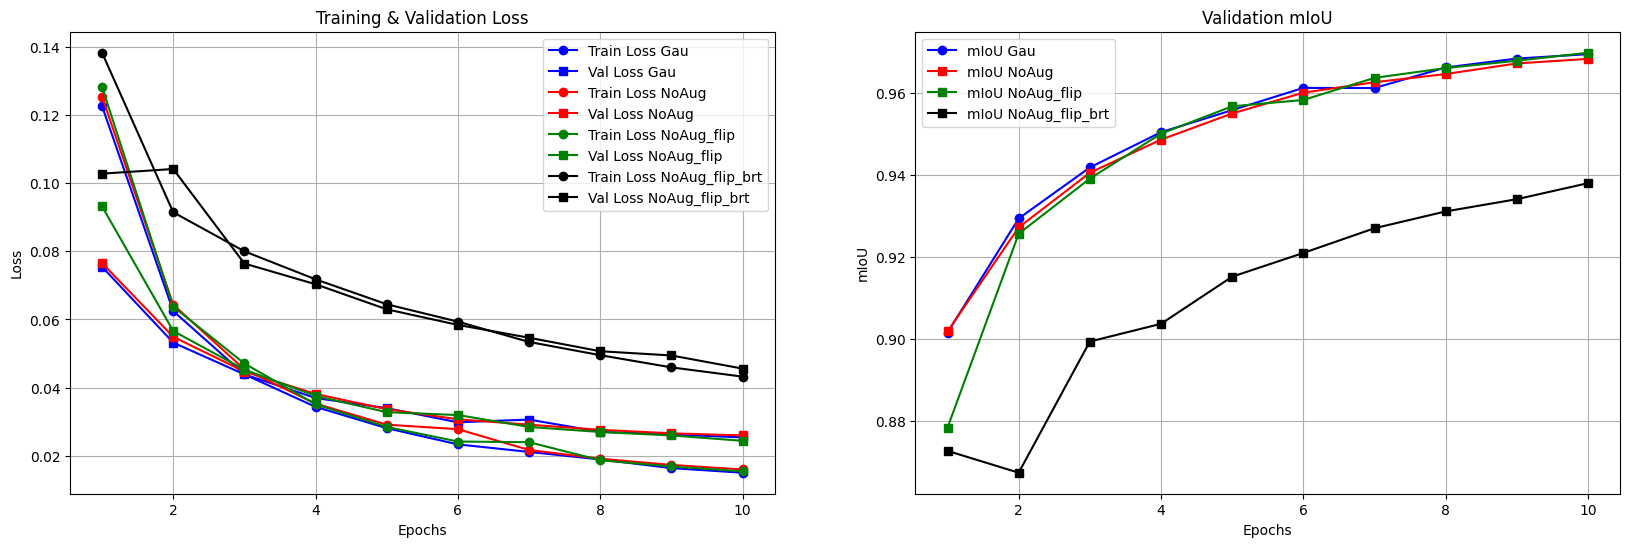

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

checkpoint_path1 = '/root/workspace/models/mit_b5_model_gau.pth'
checkpoint_path2 = '/root/workspace/models/mit_b5_model_noaug.pth'
checkpoint_path3 = '/root/workspace/models/mit_b5_model_gau_flip.pth'
checkpoint_path4 = '/root/workspace/models/mit_b5_model_gau_flip_brt.pth'


# 모델 1
if os.path.exists(checkpoint_path1):
    checkpoint = torch.load(checkpoint_path1, weights_only=False)
    train_losses1 = checkpoint.get('train_losses', [])
    val_losses1 = checkpoint.get('val_losses', [])
    mious1 = checkpoint.get('mious', [])
else:
    print("fail: checkpoint_path1")

# 모델 2
if os.path.exists(checkpoint_path2):
    checkpoint = torch.load(checkpoint_path2, weights_only=False)
    train_losses2 = checkpoint.get('train_losses', [])
    val_losses2 = checkpoint.get('val_losses', [])
    mious2 = checkpoint.get('mious', [])
else:
    print("fail: checkpoint_path2")

if os.path.exists(checkpoint_path3):
    checkpoint = torch.load(checkpoint_path3, weights_only=False)
    train_losses3 = checkpoint.get('train_losses', [])
    val_losses3 = checkpoint.get('val_losses', [])
    mious3 = checkpoint.get('mious', [])
else:
    print("fail: checkpoint_path3")

if os.path.exists(checkpoint_path4):
    checkpoint = torch.load(checkpoint_path4, weights_only=False)
    train_losses4 = checkpoint.get('train_losses', [])
    val_losses4 = checkpoint.get('val_losses', [])
    mious4 = checkpoint.get('mious', [])
else:
    print("fail: checkpoint_path3")

# epochs 설정 (모델별 길이에 맞춰)
epochs1 = range(1, len(train_losses1) + 1)
epochs2 = range(1, len(train_losses2) + 1)
epochs3 = range(1, len(train_losses3) + 1)
epochs4 = range(1, len(train_losses4) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20,6))

# Loss 비교
ax[0].plot(epochs1, train_losses1, 'b-o', label='Train Loss Gau')
ax[0].plot(epochs1, val_losses1, 'b-s', label='Val Loss Gau')
ax[0].plot(epochs2, train_losses2, 'r-o', label='Train Loss NoAug')
ax[0].plot(epochs2, val_losses2, 'r-s', label='Val Loss NoAug')
ax[0].plot(epochs3, train_losses3, 'g-o', label='Train Loss NoAug_flip')
ax[0].plot(epochs3, val_losses3, 'g-s', label='Val Loss NoAug_flip')
ax[0].plot(epochs4, train_losses4, 'k-o', label='Train Loss NoAug_flip_brt')
ax[0].plot(epochs4, val_losses4, 'k-s', label='Val Loss NoAug_flip_brt')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# mIoU 비교
ax[1].plot(epochs1, mious1, 'b-o', label='mIoU Gau')
ax[1].plot(epochs2, mious2, 'r-s', label='mIoU NoAug')
ax[1].plot(epochs3, mious3, 'g-s', label='mIoU NoAug_flip')
ax[1].plot(epochs4, mious4, 'k-s', label='mIoU NoAug_flip_brt')
ax[1].set_title('Validation mIoU')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('mIoU')
ax[1].legend()
ax[1].grid(True)

plt.show()


# simple visualization (not necessary)

torch.Size([1, 3, 512, 512])


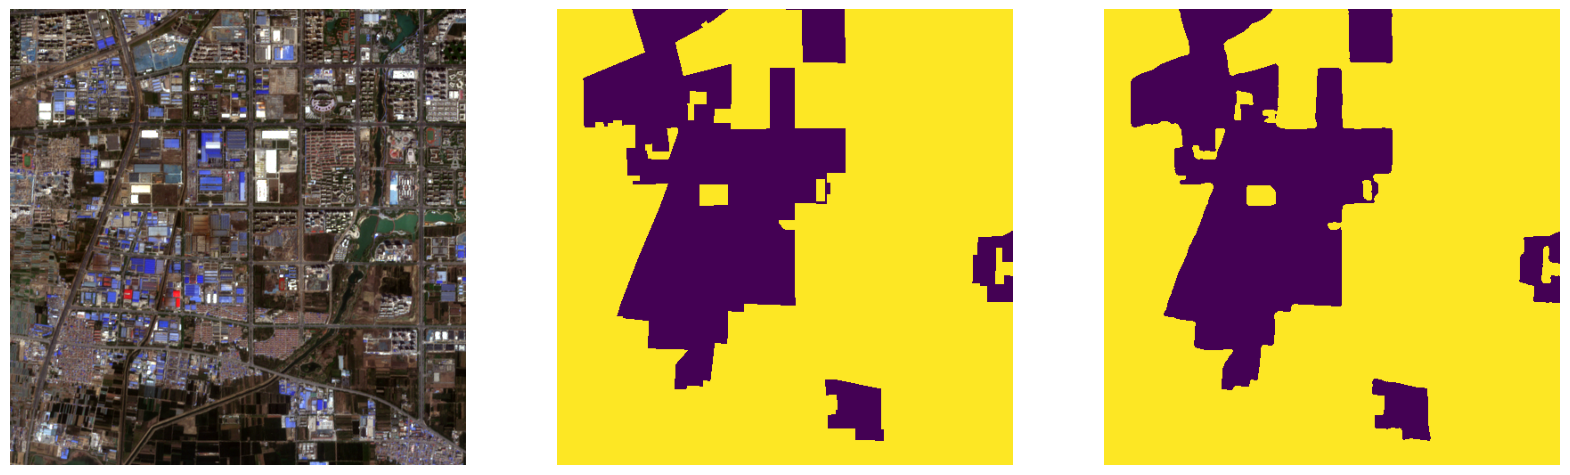

In [ ]:
file_name = '/root/workspace/train/TS_SN10_SN10/SN10_CHN_00003_230409.tif'
label_name = '/root/workspace/train/TL_SN10/SN10_CHN_00003_230409.tif'

checkpoint_path= '/root/workspace/models/mit_b5_model_gau_flip.pth'

model=smp.Unet(
  encoder_name="mit_b5",
  encoder_weights="imagenet",
  in_channels=3,
  classes=2
).to(DEVICE)


if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model'])
else:
    print("fail: checkpoint_path2")



with rasterio.open(file_name) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    red   = (red   - r_min)   / (r_max   - r_min)
    green = (green - g_min) / (g_max - g_min)
    blue  = (blue  - b_min)  / (b_max  - b_min)
    img = np.dstack((red, green, blue))
    img = img.clip(0, 1)
with rasterio.open(label_name) as src:
    label = src.read(1)
    label = (label==90).astype(np.int64)
# img, label = augmentation(img, label)
fig, ax = plt.subplots(1, 3, figsize=(20,6))
model.eval()
with torch.no_grad():
    image=torch.from_numpy(img).float().permute(2,0,1)
    image=image.unsqueeze(0).to(DEVICE)
    print(image.shape)
    prediction=model(image)
    pred=prediction.squeeze(0).argmax(0).cpu().numpy()

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].imshow(img)
ax[1].imshow(label)
ax[2].imshow(pred)